# OCT-SOX Insert

Take post D2 models, and peaks open exclusively in D2 ("neural-like"). Insert canonical OCT-SOX motifs and see increase in predicted counts.

In [2]:
import numpy as np

In [30]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [4]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [5]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [32]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx4/extra_models/P2qbCl.h5")

#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx2/2021-04-14_18_11_26/Dp2D6w.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx5/2021-04-14_18_11_26/nqv4wJ.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx8/2021-04-14_18_11_26/HhcfZk.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx1/2021-04-14_18_11_26/89fam2.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx14/2021-04-15_09_22_38/Y4lI6R.h5")
    model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/2021-04-15_09_33_42/7zunw4.h5")

In [7]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [8]:
oct_sox_hits = pd.read_csv("./data/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.200.OCTSOX.thresh7.bed", 
                           sep='\t',
                           names=["chr", "start", "end", "strand", "score", "seq"])
oct_sox_hits.head()

,chr,start,end,strand,score,seq
0,chr1,2350165,2350180,+,7.492762,CTTTGAATATAAAAT
1,chr1,5940748,5940763,+,8.132912,ATCTACATTTTAAAA
2,chr1,7263287,7263302,-,12.820701,CTTTCTTTTGCAAAT
3,chr1,7843523,7843538,-,7.100240,TTTTGTTTTTAAAAT
4,chr1,9756154,9756169,-,7.883148,ATTTCACATGAAAAT


In [9]:
first_seq = oct_sox_hits.iloc[0]
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]

>chr1:2350166-2350180
CTTTGAATATAAAAT

In [10]:
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]==first_seq['seq']

True

In [12]:
oct_sox_hits.shape

(5032, 6)

In [13]:
MODEL_INP_LEN = model.input_shape[0][1]
print(MODEL_INP_LEN)

2346


In [262]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


In [263]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 - (mid-r['start'])
        motif_end = MODEL_INP_LEN//2 + (r['end']-mid)
        # make sure seqs match
        assert(cur_raw_seqs[-1][motif_start:motif_end] == r['seq'])
        
        # replace with canonical (or something else)
        # OCTSOX: ATTTGCATAACAATG/CATTGTTATGCAAAT
        # OCTonly: ATTTGCATAAAAGAC/GTCTTTTATGCAAAT
        # KLF:  GCCACACCCAAGGAG/CTCCTTGGGTGTGGC
        # random: ACGTAGAATACTGTG
        # random: ATATATATATATATAT
        if r['strand'] == "+":
            replacement = "ATTTGCATAACAATG"
        else:
            replacement = "CATTGTTATGCAAAT"
        
        cur_raw_seqs[-1] = cur_raw_seqs[-1][:motif_start] +  replacement + cur_raw_seqs[-1][motif_end:] 
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()

100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


In [264]:
np.median(raw_pred_counts)

4.052319

In [265]:
np.median(synth_pred_counts)

3.323636

In [266]:
np.median(np.exp(synth_pred_counts-raw_pred_counts))

0.49668348

In [267]:
np.median(synth_pred_counts-raw_pred_counts)

-0.6998023

In [21]:
scipy.stats.ttest_rel(raw_pred_counts, synth_pred_counts)

Ttest_relResult(statistic=14.762073793478283, pvalue=2.6044797393420606e-48)

<AxesSubplot:>

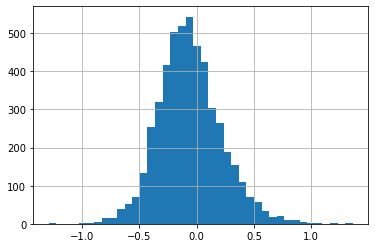

In [218]:
plt.rcParams["figure.figsize"] = (6,4)

pd.Series(synth_pred_counts-  raw_pred_counts).hist(bins=40)

Text(0, 0.5, 'A (on removing ZEB motif)')

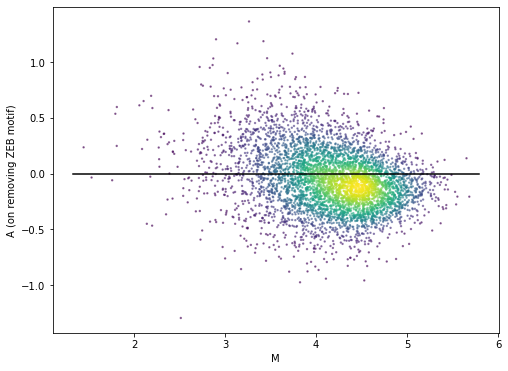

In [23]:
plt.rcParams["figure.figsize"] = (8,6)

x = (raw_pred_counts+synth_pred_counts)/2
y = (synth_pred_counts-raw_pred_counts)
xy=np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, s=2, c=z, alpha=0.5)
plt.plot([min(raw_pred_counts), max(raw_pred_counts)], [0,0], '-k', label='y=2x+1')
plt.xlabel("M")
plt.ylabel("A (on removing ZEB motif)")
# plt.savefig("image.jpg", dpi=300)

### Locus Level

In [1]:
synth_pred_counts[:20]

NameError: name 'synth_pred_counts' is not defined

In [52]:
raw_pred_counts[:20]

array([4.969944 , 4.174495 , 4.1261373, 4.6758313, 4.1133447, 3.7510118,
       3.540275 , 4.012049 , 5.0419517, 4.974635 , 4.950492 , 5.089274 ,
       3.627579 , 5.36136  , 4.4437103, 2.9317954, 3.4936674, 4.009578 ,
       4.9822288, 4.5243773], dtype=float32)

In [125]:
def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

In [33]:
import pyBigWig

In [34]:
f = pyBigWig.open("/oak/stanford/groups/akundaje/surag/projects//scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx4.bw")

In [339]:
# f.close()

In [87]:
from copy import deepcopy
import scipy

In [183]:
(7924304+7924689)//2

7924496

In [199]:
chosen_hit = oct_sox_hits.iloc[4]

chosen_hit = {"start": 7789280, "chr":"chr18"}
# {"start": 70552562, "chr":"chr8"} neural specific peak
# {"start": 7789280, "chr":"chr12"} NANOG prom centered at OS motif

midpt = chosen_hit["start"]
origseq = str(hg38[chosen_hit["chr"]][midpt-(MODEL_INP_LEN//2):midpt+(MODEL_INP_LEN//2)])

In [200]:
idx1 = (MODEL_INP_LEN//2)

In [201]:
len(origseq)

2346

In [202]:
origseq[idx1:idx1+15]

'TGCCACTGCACTCCA'

In [203]:
alt1seq = origseq[:idx1] + "TTTTGCATTACAATG" + origseq[idx1+15:]
alt2seq = origseq[:idx1] + "ATTTGCATAACAATG" + origseq[idx1+15:]
alt3seq = origseq[:idx1] + "ATATATATATATATA" + origseq[idx1+15:] 
# "ATTTGCATAACAATG/CATTGTTATGCAAAT"
# "ATATATATATATATA"

In [204]:
cur_raw_seqs = one_hot.dna_to_one_hot([origseq, alt1seq, alt2seq,alt3seq])

In [229]:
prof, cts = model.predict([cur_raw_seqs, 
               np.zeros((cur_raw_seqs.shape[0],1)), 
               np.zeros((cur_raw_seqs.shape[0],2000,2))])

In [230]:
cts

array([[4.014119 ],
       [3.909163 ],
       [3.8984687],
       [3.898752 ]], dtype=float32)

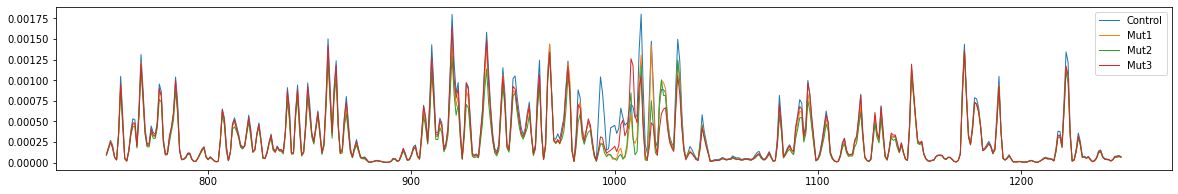

In [207]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1]))[750:1250], linewidth=1, label="Mut1")
plt.plot(range(2000)[750:1250], (softmax(prof[2]))[750:1250], linewidth=1, label="Mut2")
plt.plot(range(2000)[750:1250], (softmax(prof[3]))[750:1250], linewidth=1, label="Mut3")
# plt.plot(range(2000)[750:1250], (softmax(prof[5]))[750:1250], linewidth=1, label="All Mut")
plt.legend()

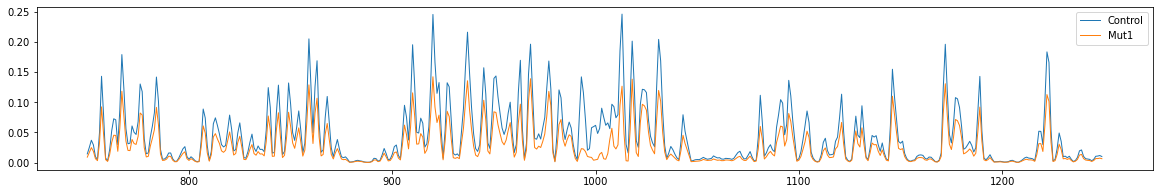

In [208]:
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(range(2000)[750:1250], (softmax(prof[0])*np.exp(cts[0]))[750:1250], linewidth=1, label="Control")
plt.plot(range(2000)[750:1250], (softmax(prof[1])*np.exp(cts[1]))[750:1250], linewidth=1, label="Mut1")
plt.legend()

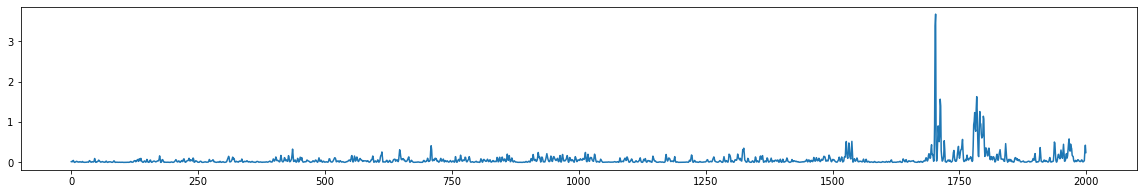

In [209]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(2000), softmax(prof[0])*np.exp(cts[0]))

In [194]:
np.sum(np.nan_to_num(f.values(chosen_hit["chr"], midpt - 1000, midpt+1000)))

114.0

[<matplotlib.lines.Line2D at 0x7f75265b4dd0>]

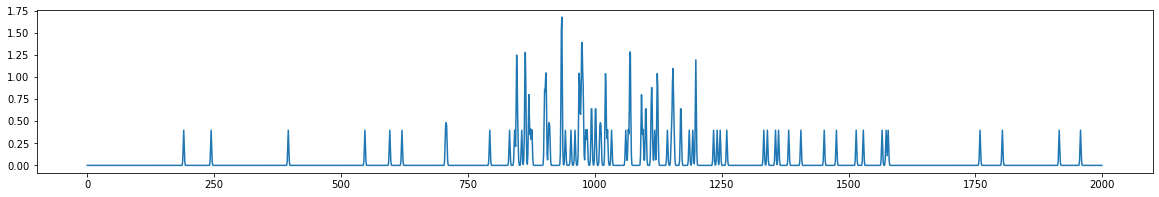

In [195]:
plt.rcParams["figure.figsize"] = (20,3)
smoothed_observed = scipy.ndimage.gaussian_filter1d(np.nan_to_num(f.values(chosen_hit["chr"], midpt - 1000, midpt+1000)), 1)
plt.plot(range(2000), smoothed_observed)

In [211]:
from shaputils import *
import shap

In [231]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model)

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[1]],
         tf.reduce_sum(model.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[2]], weightedsum_meannormed_logits),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

In [232]:
X = cur_raw_seqs
counts_shap_scores = profile_model_counts_explainer.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores = np.multiply(X, counts_shap_scores[0])

Done 0 examples of 4


In [233]:
# profile_shap_scores = profile_model_profile_explainer.shap_values(
#         [X, np.zeros((X.shape[0], 2000, 2))], progress_message=100)
# projected_shap_scores = np.multiply(X, profile_shap_scores[0])

In [234]:
from modisco.visualization import viz_sequence

TypeError: plot_weights_given_ax() got an unexpected keyword argument 'ylimits'

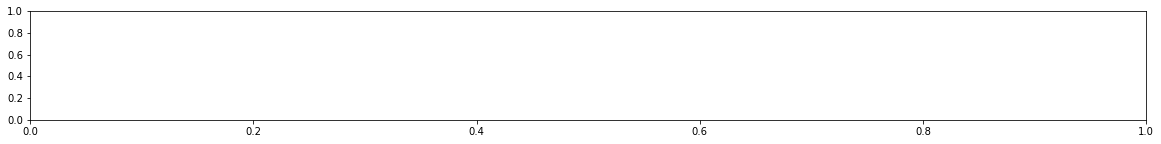

In [221]:
viz_sequence.plot_weights(projected_shap_scores[0][1023:1323], subticks_frequency=50)

(-0.06, 0.02)

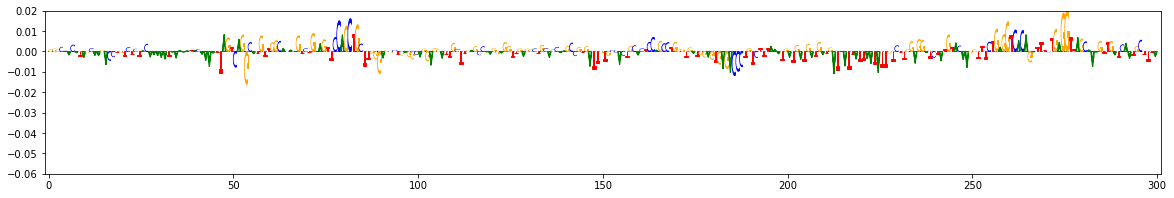

In [235]:
fig, ax= plt.subplots()
viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[0][1023:1323], subticks_frequency=50)
ax.set_ylim((-0.06,0.02))

(-0.06, 0.02)

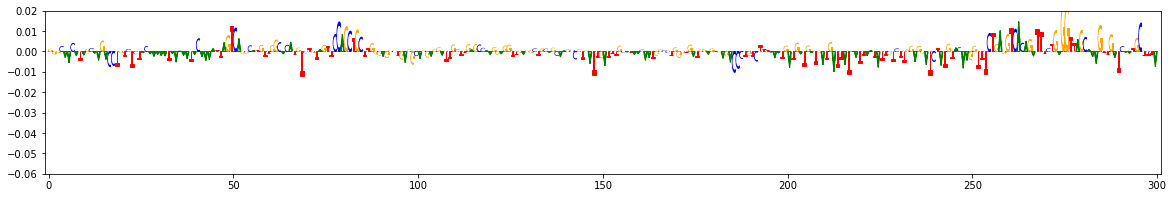

In [238]:
fig, ax= plt.subplots()
viz_sequence.plot_weights_given_ax(ax, projected_shap_scores[2][1023:1323], subticks_frequency=50)
ax.set_ylim((-0.06,0.02))

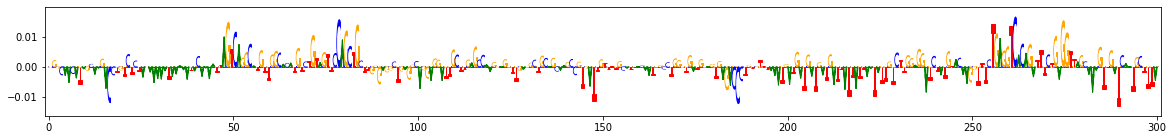

In [236]:
viz_sequence.plot_weights(projected_shap_scores[1][1023:1323], subticks_frequency=50)

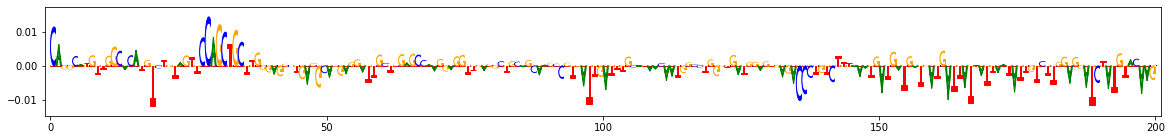

In [237]:
viz_sequence.plot_weights(projected_shap_scores[2][1073:1273], subticks_frequency=50)

## OCTSOX Saturation

Introduce OS consensus motif in random sequences. Then try for N=1..8 mutations in OS motif and measure how the predicted counts decreases with increasing mutations.

In [27]:
from random import shuffle, choice, random
from copy import deepcopy

In [15]:
random_positions = [(choice(["chr"+str(x) for x in range(1,23)]), int(random()*4e7)) for _ in range(128*1)]

In [33]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts.append(cur_pred)
    
random_pred_counts = np.vstack(random_pred_counts).ravel()

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [34]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 
        motif_end = MODEL_INP_LEN//2 + 15

        replacement = "ATTTGCATAACAATG"
        
        cur_raw_seqs[-1] = cur_raw_seqs[-1][:motif_start] +  replacement + cur_raw_seqs[-1][motif_end:]
#              replacement + cur_raw_seqs[-1][motif_end+17:motif_end+30] +\
#         replacement + cur_raw_seqs[-1][motif_end+37:]
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()

100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


In [35]:
np.median(random_pred_counts)

4.4669895

In [36]:
np.median(synth_pred_counts)

5.175356

In [20]:
def mut_str(s, n):
    assert(len(s)>=n)

    # choose n positions
    x = list(range(len(s)))
    shuffle(x)
    
    mod = list(s)
    for pos in x[:n]:
        cur_char = mod[pos]
        rep = choice([x for x in ["A","C", "G","T"] if x!=cur_char])
        mod[pos] = rep
    
    return ''.join(mod)

In [21]:
from collections import defaultdict

In [22]:
all_muts = defaultdict(list)

NUM_MUTS = 64
for i in range(1,8):
    for _ in range(NUM_MUTS):
        all_muts[i].append(mut_str("ATTTGCATAACAATG", i))

In [37]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_perturb_counts = []

for i in tqdm.tqdm(range(len(random_positions))):
    cur_seq = random_positions[i]
    cur_seq_out = []
    
    for j in range(1,8):
        cur_raw_seqs = []
            
        cur_seq_str = str(hg38[cur_seq[0]][cur_seq[1]-(MODEL_INP_LEN//2):cur_seq[1]+(MODEL_INP_LEN//2)])
        
        motif_start = MODEL_INP_LEN//2 
        motif_end = MODEL_INP_LEN//2 + 15

        for rep in all_muts[j]:
            cur_raw_seqs.append(cur_seq_str[:motif_start] + rep + cur_seq_str[motif_end:])
        
        cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
        cur_pred = model.predict([cur_raw_seqs, 
                       np.zeros((cur_raw_seqs.shape[0],1)), 
                       np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
        cur_seq_out.append(cur_pred)
    synth_pred_perturb_counts.append(cur_seq_out)

100%|██████████| 128/128 [02:10<00:00,  1.02s/it]


In [38]:
mean_perturb = [[synth_pred_counts[i]]+[np.mean(y) for y in x] for i,x in enumerate(synth_pred_perturb_counts)]
mean_perturb_norm = [(x-np.min(x))/(np.max(x)-np.min(x)) for x in mean_perturb]

In [39]:
summarized_trend = np.mean(np.array(mean_perturb_norm), axis=0)
summarized_trend_norm = (summarized_trend-np.min(summarized_trend))/(np.max(summarized_trend)-np.min(summarized_trend))

In [40]:
summarized_trend_norm_m16 = deepcopy(summarized_trend_norm)

In [140]:
# summarized_trend_norm_m4 = deepcopy(summarized_trend_norm)

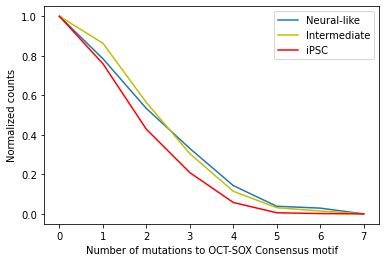

In [196]:
plt.plot(range(8), summarized_trend_norm_m4, label="Neural-like")
plt.plot(range(8), summarized_trend_norm_m8, c='y', label="Intermediate")
plt.plot(range(8), summarized_trend_norm_m16, c='r', label="iPSC")
plt.xlabel("Number of mutations to OCT-SOX Consensus motif")
plt.ylabel("Normalized counts")
plt.legend()

In [71]:
outs = []

for i in range(1,9):
    cur_batch = []
    for j in range(128):
        cur_batch.append(origseq[:idx1] + mut_str("TTTTGCATTACAATG", i) + origseq[idx1+15:])

    cur_batch = one_hot.dna_to_one_hot(cur_batch)

    _, cts = model.predict([cur_batch,               
                            np.zeros((cur_batch.shape[0],1)), 
                            np.zeros((cur_batch.shape[0],2000,2))])
    
    outs.append(cts)

NameError: name 'origseq' is not defined

In [213]:
outs_m2_scaled = np.array(outs_m2)
outs_m2_scaled = (outs_m2_scaled - np.min(outs_m2_scaled))/(np.max(outs_m2_scaled)-np.min(outs_m2_scaled))
outs_m2_scaled

array([1.        , 0.657507  , 0.31130338, 0.1323533 , 0.05320461,
       0.04444801, 0.        , 0.0448368 ], dtype=float32)

In [215]:
outs_m4_scaled = np.array(outs_m4)
outs_m4_scaled = (outs_m4_scaled - np.min(outs_m4_scaled))/(np.max(outs_m4_scaled)-np.min(outs_m4_scaled))
outs_m4_scaled

array([1.        , 0.8853634 , 0.6570377 , 0.33588824, 0.16254541,
       0.06104369, 0.03174669, 0.        ], dtype=float32)

In [188]:
outs_m2 = [np.median(x) for x in outs_m2]

In [189]:
outs_m4 = [np.median(x) for x in outs]

In [191]:
outs_m2

[6.4911656,
 6.177803,
 5.8610454,
 5.6973157,
 5.624899,
 5.616887,
 5.5762196,
 5.617243]

In [192]:
outs_m4_scaled = deepcopy(outs_m4)

In [190]:
outs_m4

[4.257821,
 4.176708,
 4.015153,
 3.7879188,
 3.6652675,
 3.5934484,
 3.5727189,
 3.550256]

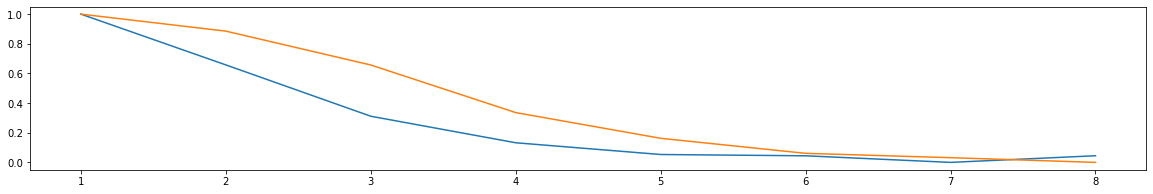

In [216]:
plt.plot(range(1,9), outs_m2_scaled)
plt.plot(range(1,9), outs_m4_scaled)

In [136]:
prof, cts = model.predict([cur_raw_seqs, 
               np.zeros((cur_raw_seqs.shape[0],1)), 
               np.zeros((cur_raw_seqs.shape[0],2000,2))])

In [137]:
cts

array([[6.4720035],
       [6.4720035],
       [6.1348853],
       [5.696903 ]], dtype=float32)